In [1]:
# start here
%run ./ClinicalTrialFunctions.py

### load pipeline and global variables
spacy_nlp = getSpacyNLP()
#stanza_nlp = getStanzaNLP()

# load stopwords
all_stopwords = spacy_nlp.Defaults.stop_words
all_stopwords |= {"patient", "subject", "participant", "studies", "study",
                  "individual", "e.g.",  "diagnosis", "participation", "participate"} 

# load mesh values
mesh_dict = meshIDToBranchDict()

# set style
sns.set_style("white")
sns.set_context("talk")


2022-09-13 08:51:40.930 INFO    nmslib: Loading index from /Users/bmiao/.scispacy/datasets/7e3c2133fa65605a10eb67a4cfedf8d69bc553cf192dc9d883de80b803c89c5d.fb99c660e797fcb5f0a59c23a58316e9027046d6fb0519d1ae715099da1e5baa.nmslib_index.bin
2022-09-13 08:51:40.935 INFO    nmslib: Loading regular index.
2022-09-13 08:51:41.233 INFO    nmslib: Finished loading index
2022-09-13 08:51:41.235 INFO    nmslib: Set HNSW query-time parameters:
2022-09-13 08:51:41.235 INFO    nmslib: ef(Search)         =20
2022-09-13 08:51:41.236 INFO    nmslib: algoType           =2
2022-09-13 08:51:41.237 INFO    nmslib: Set HNSW query-time parameters:
2022-09-13 08:51:41.237 INFO    nmslib: ef(Search)         =200
2022-09-13 08:51:41.238 INFO    nmslib: algoType           =2


# DTx clinical trials

## ClinicalTrials.gov search strategy


In [4]:
### Retrieve DTx clinical trials
# search terms
queries = ["digital therapeutic", "digital therapy","digital therapies", 
           "mobile health", 'smartphone', "smart phone", "digital intervention",
           "mobile platform", "mobile app","mobile device", 'study app', #"google fit", "apple health",
               "digital treatment", "android", ' app.',' app,', "digital tablet", #"apple watch", "fitbit",
               " ios", "iphone", "smart watch", "smartwatch","virtual reality", 
               "video game", "digital health", "mobile video", "digital platform",  "software intervention",
           "software treatment"]

fields_list = {"Metadata": ["NCTId", "OverallStatus", "StartDate", "EligibilityCriteria","CompletionDate",
                            "StudyType", "BriefTitle","DesignPrimaryPurpose", "LeadSponsorClass",  "CollaboratorClass", 
                            "DetailedDescription", "IsFDARegulatedDevice", "IsFDARegulatedDrug","InterventionType",
                            "BriefSummary", "OfficialTitle", "Keyword",  "InterventionDescription", "InterventionName",                       
                           ]} 
    
# get clinical trials that match specific search fields
search_fields = ["BriefSummary", "InterventionName", "InterventionDescription", "BriefTitle",
                 "Keyword", "DetailedDescription", "OfficialTitle", "EligibilityCriteria"]
full_query_df = pd.DataFrame(columns=["NCTId"])
for q in queries:
    q = '"'+q+'"'
    print(q)
    clinical_df = pd.DataFrame(columns=["NCTId"])
    for key in fields_list.keys(): 
        curr_df = queryClinicalTrialsAPI(q, fields_list[key], search_field=search_fields)
        clinical_df = clinical_df.merge(curr_df, how="outer", left_on="NCTId", right_on="NCTId")
    clinical_df["query"]=q
    print(len(clinical_df))
    full_query_df = full_query_df.append(clinical_df)

full_query_df = full_query_df.drop_duplicates(subset=["NCTId"])
#full_query_df.to_csv("./exampleFile/DTxClinicalTrials.csv")




"digital therapeutic"
76
"digital therapy"
33
"digital therapies"
33
"mobile health"
1598
"smartphone"
3219
"smart phone"
3219
"digital intervention"
156
"mobile platform"
53
"mobile app"
1834
"mobile device"
462
"study app"
48
"digital treatment"
27
"android"
401
" app."
1265
" app,"
766
"digital tablet"
21
" ios"
340
"iphone"
219
"smart watch"
83
"smartwatch"
140
"virtual reality"
1747
"video game"
598
"digital health"
388
"mobile video"
12
"digital platform"
120
"software intervention"
7
"software treatment"
8


In [9]:
### Load results 
clinical_df = pd.read_csv("./exampleFile/DTxClinicalTrials.csv", index_col=0)

# check to make sure that values are actually occuring in correct fields
    # because the API search has a bug - not actually limited to search fields provided

search_fields = ["BriefSummary", "InterventionName", "InterventionDescription", "BriefTitle",
                 "Keyword", "DetailedDescription", "EligibilityCriteria", "OfficialTitle"]

queries = ["digital therapeutic", "digital therapy","digital therapies", 
           "mobile health", 'smartphone', "smart phone", "digital intervention",
           "mobile platform", "mobile app","mobile device", 'study app', #"google fit", "apple health",
               "digital treatment", "android", ' app.',' app,', "digital tablet", #"apple watch", "fitbit",
               " ios", "iphone", "smart watch", "smartwatch", "virtual reality", 
               "video game", "digital health", "mobile video", "digital platform",  "software intervention",
           "software treatment"]

NCT_list = filterCTQueriesByCol(clinical_df, search_fields, queries)
clinical_df = clinical_df[clinical_df["NCTId"].isin(NCT_list)]
print("Total trials: %s"%len(clinical_df))

# remove inactive trials
remove_status = ["Terminated", "Unknown status", "Withdrawn", "Suspended", "No longer available"]
clinical_df = clinical_df[~(clinical_df["OverallStatus"].isin(remove_status))]
print("active trials: %s"%len(clinical_df))

# limit to trials starting after 2009-12-31 AND completed (or expected to be completed) by 2031-01-01
for col in ["CompletionDate", "StartDate"]:
    clinical_df[col] = [s if type(s)!=str 
                    else np.nan if s ==""
                     else datetime.strptime(s, '%Y-%m-%d') if "-" in s
                     else datetime.strptime(s, '%B %d, %Y') if "," in s
                     else datetime.strptime(formatDate(s), '%m/%d/%y') if "/" in s
                     else datetime.strptime(s, '%B %Y') for s in clinical_df[col]]

    clinical_df[col] = [d if type(d)!=str else d.strftime('%Y-%m-%d') for d in clinical_df[col]]

clinical_df = clinical_df[clinical_df["StartDate"] > "2009-12-31"]
print("Start date after 2010: %s"%len(clinical_df))
clinical_df = clinical_df[clinical_df["CompletionDate"] < "2031-01-01"]
print("End date before 2030: %s"%len(clinical_df))

# limit to FDA regulated devices
clinical_df = clinical_df[clinical_df["IsFDARegulatedDevice"] == "Yes"]
print("FDA regulated trials: %s"%len(clinical_df))

# removes basic science trials
clinical_df = clinical_df[~clinical_df["DesignPrimaryPurpose"].isin(["Basic Science"])] #, "Screening", "Other", "Treatment", "Prevention"
print("Non-basic science trials: %s"%len(clinical_df))

# Deprecated: remove Intervention Type == ["Drug", "Biological/Vaccine", "Procedure/Surgery", "Radiation"]
# clinical_df = clinical_df[clinical_df["InterventionType"].str.contains('|'.join(["Combination Product", "Device", "Other", "Behavioral", "Diagnostic Test", "nan"]))]
print("Final filtered trials: %s"%len(clinical_df))

#save to file
clinical_df.to_csv("./exampleFile/DTxClinicalTrials_filtered.csv")



Total trials: 8615
active trials: 7386
Start date after 2010: 7254
End date before 2030: 7221
FDA regulated trials: 458
Non-basic science trials: 449
Final filtered trials: 449


## Full data retrieval and preprocessing
The complete record for each clinical trial was then extracted from the full dataset downloaded from ClinicalTrials.gov (downloaded July 25, 2022) for downstream analysis. 


In [233]:
# Load full dataset
clinical_df = pd.read_csv("./exampleFile/DTxClinicalTrials_filtered.csv", index_col=0)
clinical_df = loadLocalNCTData(clinical_df["NCTId"])

# Add collaborators metadata
clinical_df["CollaboratorName"] = extractDictValuesFromList(clinical_df["Collaborator"], key="CollaboratorName")
clinical_df["CollaboratorClass"] = extractDictValuesFromList(clinical_df["Collaborator"], key="CollaboratorClass")
clinical_df["NumberCollaborators"] = [len(x) if type(x)==list else 0 for x in clinical_df["CollaboratorName"]]
clinical_df["PrimaryCollaboratorClass"] = collapseCollaboratorType(clinical_df["CollaboratorClass"], multiple="group")


# Add trial duration metadata
clinical_df["StartDate"] = convertToDatetime(clinical_df["StartDate"])
clinical_df["PrimaryCompletionDate"] = convertToDatetime(clinical_df["PrimaryCompletionDate"])
clinical_df["CompletionDate"] = convertToDatetime(clinical_df["CompletionDate"])

clinical_df["StartYear"] = [s.year if type(s)!=str else np.nan for s in clinical_df["StartDate"]]
clinical_df["PrimaryCompletionYear"] = [s.year if type(s)!=str else np.nan for s in clinical_df["PrimaryCompletionDate"]]
clinical_df["CompletionYear"] = [s.year if type(s)!=str else np.nan for s in clinical_df["CompletionDate"]] 
clinical_df["TrialDurationYears"] = getTrialDurations(clinical_df["StartDate"], clinical_df["CompletionDate"])
clinical_df["TrialPrimaryDurationYears"] = getTrialDurations(clinical_df["StartDate"], clinical_df["PrimaryCompletionDate"])
    
"""
# Format dates
for col in ["CompletionDate", "StartDate"]:
    clinical_df[col] = [s if type(s)!=str 
                    else np.nan if s ==""
                     else datetime.strptime(s, '%Y-%m-%d') if "-" in s
                     else datetime.strptime(s, '%B %d, %Y') if "," in s
                     else datetime.strptime(formatDate(s), '%m/%d/%y') if "/" in s
                     else datetime.strptime(s, '%B %Y') for s in clinical_df[col]]

    clinical_df[col] = [d if type(d)!=str else d.strftime('%Y-%m-%d') for d in clinical_df[col]]
"""

# Add location metadata for US and canada
clinical_df["NumberLocations"] = [len(x) if type(x)==list else 0 for x in clinical_df["Location"]]

for l in ["LocationFacility", "LocationStatus", "LocationCity", "LocationState", "LocationZip", "LocationCountry"]:
    clinical_df[l] = extractDictValuesFromList(clinical_df["Location"], key=l)

getTrialLocations(clinical_df['LocationZip'], country="us")
getTrialLocations(clinical_df['LocationZip'], country="ca")

loc_df = mapTrialLocations(clinical_df[["NCTId", "LocationZip"]])
del loc_df["LocationZip"]
clinical_df = clinical_df.merge(loc_df, how="left", left_on="NCTId", right_on="NCTId")

# Average enrollment values
clinical_df["EnrollmentCount"] = pd.to_numeric(clinical_df["EnrollmentCount"])
clinical_df["EnrollmentAvg"] = clinical_df["EnrollmentCount"].divide(clinical_df["NumberLocations"], fill_value=0)

# Clean eligibility criteria
elig_df = extractInclusionExclusionCriteria(clinical_df[["NCTId", "EligibilityCriteria"]])
clinical_df = clinical_df.merge(elig_df, how="outer", left_on="NCTId", right_on="NCTId")
clinical_df["IncCriteriaClean"] = cleanTextValues(clinical_df["InclusionCriteria"], stopwords=all_stopwords) 
clinical_df["ExCriteriaClean"] = cleanTextValues(clinical_df["ExclusionCriteria"], stopwords=all_stopwords) 

# Deprecated: Extract eligibility entities by Stanza (takes about 5 min to run)
#clinical_df["InclusionEnts"], clinical_df["InclusionEntTypes"] = extractStanzaEnts(clinical_df["IncCriteriaClean"], stanza_nlp=stanza_nlp)
#clinical_df["ExclusionEnts"], clinical_df["ExclusionEntTypes"] = extractStanzaEnts(clinical_df["ExCriteriaClean"], stanza_nlp=stanza_nlp)

# Extract conditions into MeSH branches using Scispacy
clinical_df["conditionMesh"] = extractConditionMeshBranch(clinical_df["Condition"], **{"_nlp":spacy_nlp, "mesh_dict":mesh_dict})
clinical_df["conditionMeshMainBranch"] = [collapseMeshEnts(m) for m in clinical_df["conditionMesh"]]

# some manual mapping
clinical_df["conditionMeshMainBranch"] = [m if m!="Unknown"
                             else "Pathological Conditions, Signs and Symptoms" if "pain" in "".join(c).lower() 
                            else "Pathological Conditions, Signs and Symptoms" if "headache" in "".join(c).lower()
                             else "Infections" if "hiv" in "".join(c).lower() 
                             else "Infections" if "covid" in "".join(c).lower() 
                             else "Infections" if "sars-cov" in "".join(c).lower() 
                             else "Chemically-Induced Disorders" if "opioid" in "".join(c).lower() 
                             else "Mental Disorders" if "eating disorder" in "".join(c).lower() 
                             else "Nervous System Diseases" if "stroke" in "".join(c).lower() 
                             else "Cardiovascular Diseases" if "atrial" in "".join(c).lower() 
                             else "Nervous System Diseases" if "".join(c).lower() == 'als'
                             else "Unknown" for m,c in zip(clinical_df["conditionMeshMainBranch"], clinical_df["Condition"]) ]

# Extract primary outcomes timeline, takes a couple of seconds
clinical_df["PhaseClean"] = [np.nan if type(x)==float else ", ".join(list(x)) for x in clinical_df["Phase"]]
for k in ["Measure", "Description", "TimeFrame"]:
    clinical_df["PrimaryOutcome%s"%k] = extractDictValuesFromList(clinical_df["PrimaryOutcome"], key="PrimaryOutcome%s"%k)

clinical_df["PrimaryTimeframeClean"] = cleanTimeValues(clinical_df["PrimaryOutcomeTimeFrame"])
clinical_df["PrimaryTimeframeExtracted"] = extractTimeframeValues(clinical_df["PrimaryTimeframeClean"])
clinical_df["PrimaryTimeframeExtractedMonths"] = convertOutcomeTimeframeValues(clinical_df["PrimaryTimeframeExtracted"], convert_to="month")
clinical_df["PerPrimaryOutcomeLongestMonths"], clinical_df["OverallPrimaryOutcomeLongestMonths"] = extractOverallLongestTimeframe(clinical_df["PrimaryTimeframeExtractedMonths"])

# Extract reference values
for r in ["ReferenceCitation", "ReferencePMID", "ReferenceType"]:
    clinical_df[r] = extractDictValuesFromList(clinical_df["Reference"], key=r)

clinical_df.to_parquet('./exampleFile/DTxClinicalTrials.parquet.gzip', compression='gzip')




# Figure 2: Basic characteristics

StudyType     
Interventional    396
Observational      53
dtype: int64
StudyType       OverallStatus          
Interventional  Completed                  150
                Recruiting                 146
                Not yet recruiting          48
                Active, not recruiting      30
Observational   Recruiting                  24
Interventional  Enrolling by invitation     22
Observational   Completed                   18
                Not yet recruiting           6
                Active, not recruiting       3
                Enrolling by invitation      2
dtype: int64
PhaseClean      
Not Applicable      360
Phase 2              12
Phase 4               7
Phase 1               5
Phase 3               5
Phase 2, Phase 3      4
Early Phase 1         3
dtype: int64
Study first post years
StudyType       PostYear
Interventional  2012         2
                2014         1
                2015         5
                2016         6
                2017        31
    

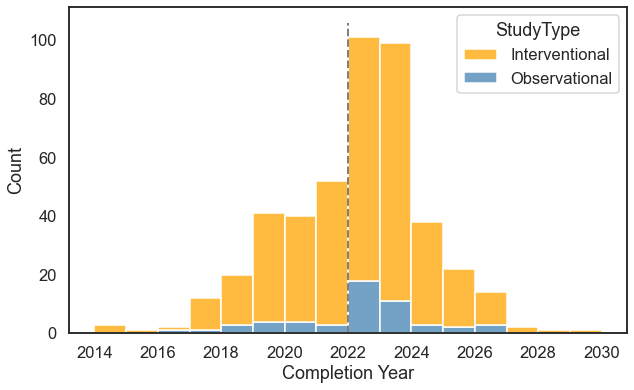

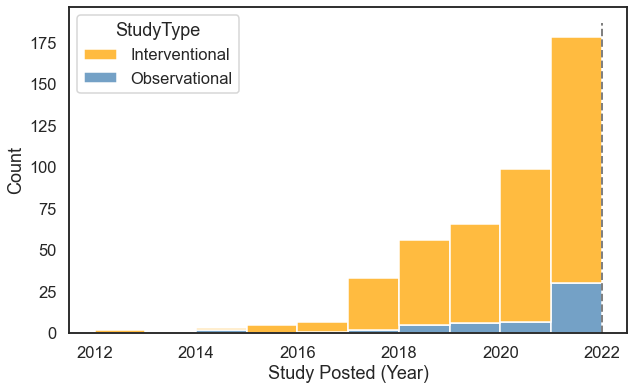

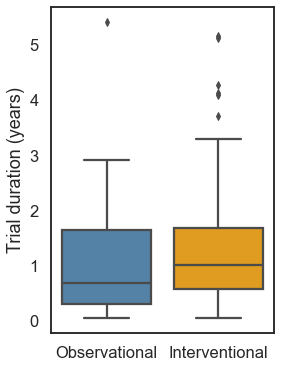

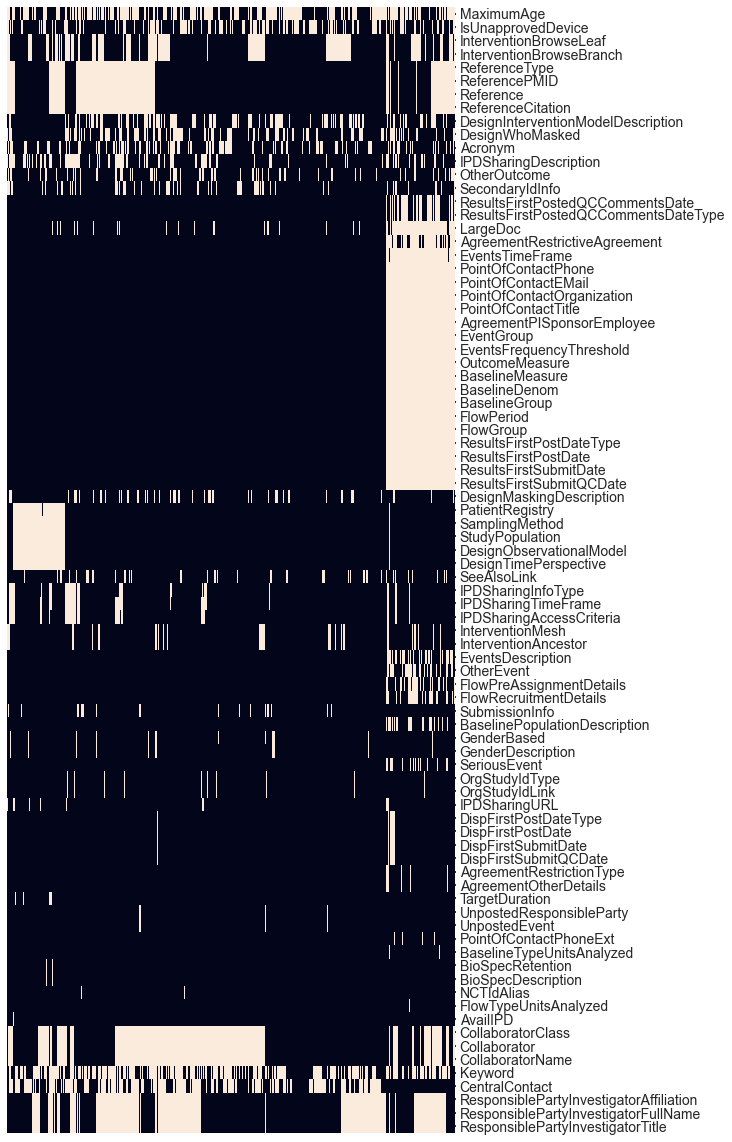

In [68]:
%run ./ClinicalTrialFunctions.py

## Load full data records
clinical_df = pd.read_parquet('./exampleFile/DTxClinicalTrials.parquet.gzip')
colors = {'Observational': "steelblue", 'Interventional': "orange"}

## Figure 2B: Trials over time
fig = plotCompletionYear(clinical_df, colors=colors, figsize=(10,6))
fig.show()
fig.savefig("./dataOutput/figures/Figure1_TrialCompletionYear.pdf")
print(clinical_df.value_counts(["StudyType"]))
print(clinical_df.value_counts(["StudyType","OverallStatus"]))
print(clinical_df.value_counts(["PhaseClean"]))

### Figure S2A:
clinical_df["StudyFirstPostDate"] = convertToDatetime(clinical_df["StudyFirstPostDate"])
clinical_df["PostYear"] = [s.year if type(s)!=str else np.nan for s in clinical_df["StudyFirstPostDate"]] 
fig = plotCompletionYear(clinical_df, x_values="PostYear", colors=colors, xlabel="Study Posted (Year)", figsize=(10,6))
fig.show()
fig.savefig("./dataOutput/figures/FigureS1_TrialPostDate.pdf")
print("Study first post years")
print(clinical_df.value_counts(["StudyType","PostYear"], sort=False))

## Figure 2C: Overall trial duration for completed trials
clinical_df = clinical_df[clinical_df["OverallStatus"] == "Completed"]
fig = plotStudyDuration(clinical_df, colors=colors, figsize=(4,6))
fig.show()
fig.savefig("./dataOutput/figures/Figure1_TrialDuration.pdf")

### Study duration metrics (completed studies only)
print()
printStudyMetrics(clinical_df, study_type="Interventional", values = "TrialDurationYears", metrics=["count", "median", "std"])
printStudyMetrics(clinical_df, study_type="Observational", values = "TrialDurationYears", metrics=["count", "median", "std"])

print(mannWhitneyLongDf(clinical_df, subset_col=None, values_col="TrialDurationYears", labels_col="StudyType", 
            sig_only=False, min_values=5, correct=False))

## Supplemental figure S2A: Phase (completed studies only, supplement)
#_plotCompletionYear(clinical_df, colors = None, hue="PhaseClean")

## Supplemental figure S2B: Missingness (all studies, supplement)
clinical_df = pd.read_parquet('./exampleFile/DTxClinicalTrials.parquet.gzip')
fig = plotMissingness(clinical_df)
fig.savefig("./dataOutput/figures/FigureS2_Missingness.pdf")




# Figure 3: Location and sponsor characteristics


LocationState
California          135
New York             58
Florida              55
NA                   54
Pennsylvania         52
                   ... 
North Dakota          1
Northamptonshire      1
Bavaria               1
Bad-wur               1
Yorkshire             1
Length: 83, dtype: int64
State population vs # trial sites:  SpearmanrResult(correlation=0.8921659881397217, pvalue=8.682436923475349e-17)

# trial sites vs ADI:  SpearmanrResult(correlation=-0.5220533431972995, pvalue=6.821513292554924e-07)
# trial sites vs ADI:  SpearmanrResult(correlation=-0.6626170426112704, pvalue=0.03680640234866444)
Mean, min, max locations per completed trial: 2.333, 0, 66
Studies with no locations: 4




Total overall = 449

OTHER        290
INDUSTRY     146
FED           11
NIH            1
OTHER_GOV      1
Name: LeadSponsorClass, dtype: int64
OTHER        0.645880
INDUSTRY     0.325167
FED          0.024499
NIH          0.002227
OTHER_GOV    0.002227
Name: LeadSponsorClass, dtype: float64

0    236
1    131
2     45
3     19
4     12
5      4
8      1
7      1
Name: NumberCollaborators, dtype: int64
0    0.525612
1    0.291759
2    0.100223
3    0.042316
4    0.026726
5    0.008909
8    0.002227
7    0.002227
Name: NumberCollaborators, dtype: float64

Total for 1 collaborator= 131

LeadSponsorClass  CollaboratorClass
OTHER             INDUSTRY             26
                  UNKNOWN              24
                  OTHER                19
                  NIH                  18
INDUSTRY          OTHER                14
                  UNKNOWN               9
                  INDUSTRY              6
OTHER             FED                   6
INDUSTRY          NIH                

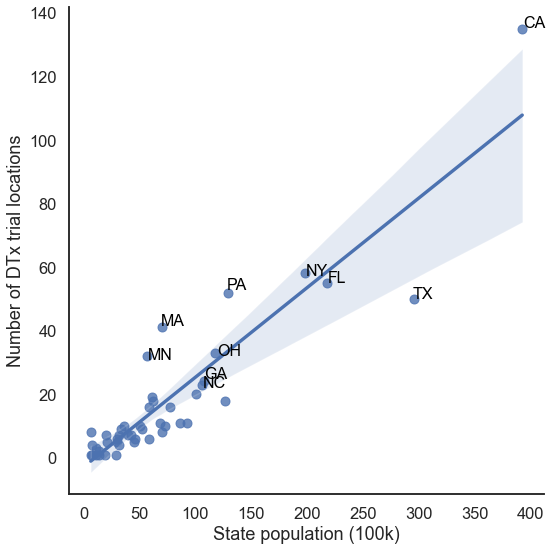

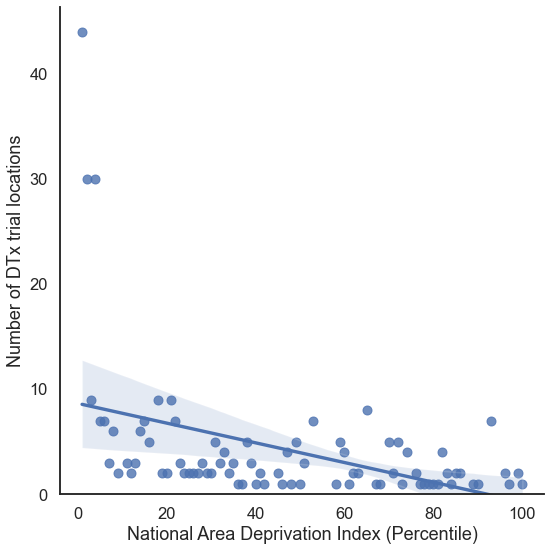

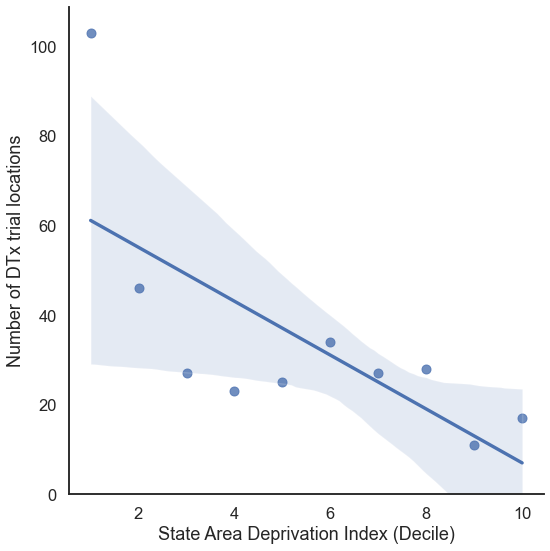

In [44]:
%run ./clinicalTrialFunctions.py
clinical_df = pd.read_parquet('./exampleFile/DTxClinicalTrials.parquet.gzip')

## Figure 3A: Locations by state
fig = plotGeographicDistributionbyState(clinical_df[["NCTId", "state_code"]], values=None, average="sum", log_value=None)
fig.show()
fig.write_image("./dataOutput/figures/Figure2_Locations.pdf")
locations_df = clinical_df.explode(["LocationState"])
print(locations_df.value_counts("LocationState"))

## Supplemental figure S3A: Locations by state normalized to population
state_code_dict = {}
for m, n in zip(clinical_df["LocationState"], clinical_df["state_code"]):
    if m is not None and n is not None and len(m) == len(n): state_code_dict.update(dict(zip(m,n)))
fig, state_df = plotPerPopulationTrial(locations_df.value_counts("LocationState"), state_code_dict, normalize=10e4)
#fig.show() # Normalized to population
fig = plotPopulationvsNumTrialLocations(state_df, min_label=22)
fig.get_figure().savefig("./dataOutput/figures/FigureS3_TrialsVsStatePopulation.pdf")
print()

## Supplemental figure S3B/C: Number of clincal trial locations by ADI
# getLocationZipADI() takes some time to run
state_df = getLocationZipADI(clinical_df, states=["CA", "TX", "FL", "NY", "PA"])
clinical_df["ADI_NATRANK"] = clinical_df["NCTId"].map(state_df.groupby("NCTId")["ADI_NATRANK"].apply(list))
clinical_df["ADI_STATERNK"] = clinical_df["NCTId"].map(state_df.groupby("NCTId")["ADI_STATERNK"].apply(list))

fig = plotTrialLocationsPerADI(state_df, rank_type="ADI_NATRANK", height=8)
fig.set_xlabel("National Area Deprivation Index (Percentile)")
fig.get_figure().savefig("./dataOutput/figures/FigureS3_TrialsVsADINational.pdf")

fig = plotTrialLocationsPerADI(state_df, rank_type="ADI_STATERNK", height=8)
fig.set_xlabel("State Area Deprivation Index (Decile)")
fig.get_figure().savefig("./dataOutput/figures/FigureS3_TrialsVsADIState.pdf")

## Print average number of locations per trial (completed only)
clinical_df = clinical_df[clinical_df["OverallStatus"] == "Completed"]
#clinical_df = clinical_df[clinical_df["StudyType"] == "Interventional"]
print("Mean, min, max locations per completed trial: %.3f, %d, %d"%(clinical_df["NumberLocations"].mean(), clinical_df["NumberLocations"].min(), clinical_df["NumberLocations"].max()))
print("Studies with no locations: %d\n"%(len(clinical_df[clinical_df["NumberLocations"] == 0])))
print()

"""
## Supplemental figure S3B: Number of locations vs enrollment (completed studies only)
clinical_df["Log10EnrollmentCount"] = np.log10(clinical_df["EnrollmentCount"])
lm = sns.lmplot(data = clinical_df, x = "NumberLocations", y= "Log10EnrollmentCount", height=10, )
ax = lm.axes[0,0]
ax.set_xlabel("Number of trial locations")
ax.set_ylabel("Enrollment (Log10)")   
print("#locations vs enrollment", spearmanr(clinical_df["NumberLocations"], clinical_df["Log10EnrollmentCount"]))
"""
## Figure 3B: Sponsor type
clinical_df = pd.read_parquet('./exampleFile/DTxClinicalTrials.parquet.gzip')
fig = plotSponsorCollaborations(clinical_df[["NCTId", "LeadSponsorClass", "PrimaryCollaboratorClass"]],
                          collab_col="PrimaryCollaboratorClass", explode_collaborators=False)
fig.show()
fig.write_image("./dataOutput/figures/Figure2_Sponsors.pdf")

## Overall metrics
total = len(clinical_df)
print("Total overall = %d\n"%total)
for col in ["LeadSponsorClass", "NumberCollaborators"]: #, "PrimaryCollaboratorClass"
    print(clinical_df[col].value_counts())
    print(clinical_df[col].value_counts()/total)
    print()

## Metrics for trials with 1 collaborators
curr_df = clinical_df[clinical_df["NumberCollaborators"]==1]

total = len(curr_df)
print("Total for 1 collaborator= %d\n"%total)
curr_df = curr_df.explode("CollaboratorClass")
print(curr_df[["LeadSponsorClass", "CollaboratorClass"]].value_counts())
print(curr_df[["LeadSponsorClass", "CollaboratorClass"]].value_counts() / total)




# Figure 4: Characteristics and MeSH groups

Nervous System Diseases                        82
Nutritional and Metabolic Diseases             45
Pathological Conditions, Signs and Symptoms    41
Behavior and Behavior Mechanisms               36
Cardiovascular Diseases                        34
Mental Disorders                               31
Neoplasms                                      22
Respiratory Tract Diseases                     18
Infections                                     15
Psychological Phenomena                        13
Name: conditionMeshMainBranch, dtype: int64

Nervous System Diseases                        0.185102
Nutritional and Metabolic Diseases             0.101580
Pathological Conditions, Signs and Symptoms    0.092551
Behavior and Behavior Mechanisms               0.081264
Cardiovascular Diseases                        0.076749
Mental Disorders                               0.069977
Neoplasms                                      0.049661
Respiratory Tract Diseases                     0.040632
Infecti

,pval,Anticipated median,Actual median
Nutritional and Metabolic Diseases,0.035231,260.0,49.5


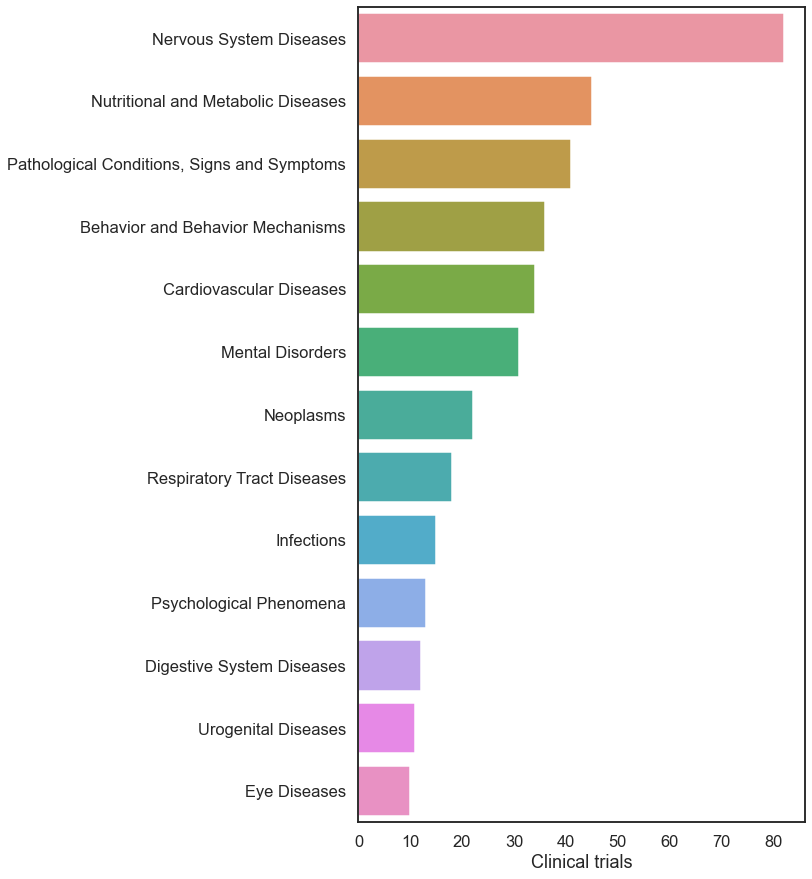

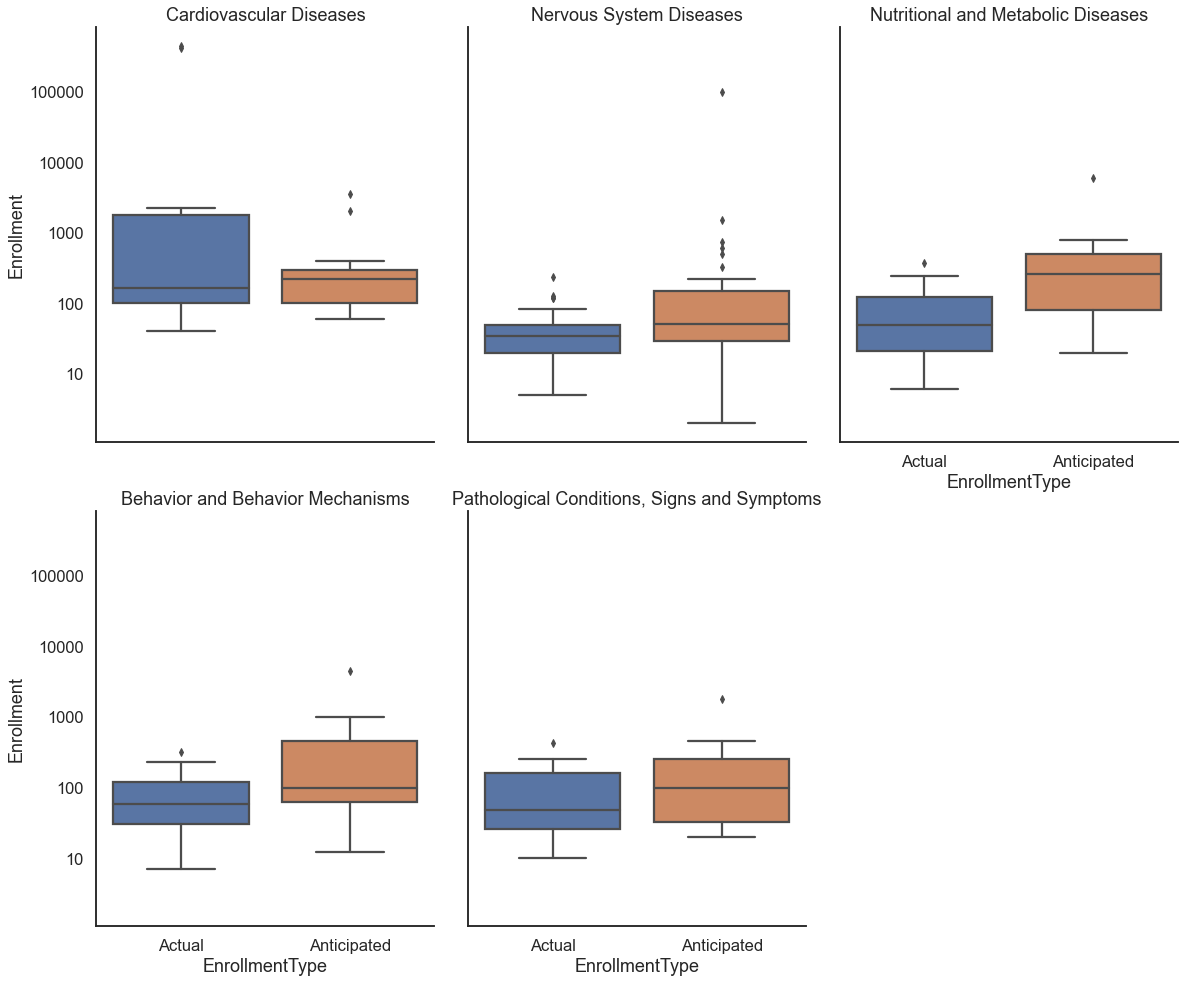

In [370]:
%run ./clinicalTrialFunctions.py
clinical_df = pd.read_parquet('./exampleFile/DTxClinicalTrials.parquet.gzip')

## Remove unmapped values
clinical_df = clinical_df[clinical_df["conditionMeshMainBranch"] != "Unknown"]

## Figure 4A: Mesh branch counts (at least 10 in group)
fig = plotMeshBranchCounts(clinical_df[["conditionMeshMainBranch"]], min_count=10)
fig.savefig("./dataOutput/figures/Figure3_MeshGroupCounts.pdf", bbox_inches="tight")
print(clinical_df["conditionMeshMainBranch"].value_counts()[:10])
print()
print(clinical_df["conditionMeshMainBranch"].value_counts()[:10]/len(clinical_df["conditionMeshMainBranch"]))

## Remove phase I trials 
clinical_df = clinical_df[clinical_df["PhaseClean"] != "Phase 1"]
clinical_df = clinical_df[~clinical_df["conditionMeshMainBranch"].isna()]

## Remove non-interventional trials & trials with fewer than 10 trials
clinical_df = clinical_df[clinical_df["StudyType"] == "Interventional"]
mesh_ind = clinical_df["conditionMeshMainBranch"].value_counts().loc[lambda x: x>10].index
clinical_df = clinical_df[clinical_df["conditionMeshMainBranch"].isin(mesh_ind)]

## Figure 4B: Actual vs anticipated enrollment by MeSH branch
g, condition_df = plotCompareMeshGroupValues(clinical_df[["EnrollmentCount", "conditionMeshMainBranch", "EnrollmentType"]], 
                                          n_col=3, counts_col="EnrollmentCount", x_col="EnrollmentType", 
                                          mesh_col="conditionMeshMainBranch", min_len=10)
g.savefig("./dataOutput/figures/Figure3_MeshGroupEnrollments.pdf")

## Metrics for average values
#sort_order = mesh_df.groupby(mesh_col)[counts_col].median().sort_values(ascending=False).index
printEnrollmentMetrics(condition_df, values=None)

## Statistics for actual vs anticipated values
_mannWhitneyLongDf(condition_df, values_col="EnrollmentCount", min_values=10,
                  labels_col="EnrollmentType",subset_col="conditionMeshMainBranch")




# Figure 5: Eligibility criteria

In [17]:
%run ./clinicalTrialFunctions.py

clinical_df = pd.read_parquet('./exampleFile/DTxClinicalTrials.parquet.gzip')

## Remove phase 1-4 trials 
clinical_df = clinical_df[clinical_df["PhaseClean"] == "Not Applicable"]
clinical_df = clinical_df[~clinical_df["conditionMeshMainBranch"].isna()]

## Remove non-interventional trials & trials with fewer than 10 trials
clinical_df = clinical_df[clinical_df["StudyType"] == "Interventional"]
mesh_ind = clinical_df["conditionMeshMainBranch"].value_counts().loc[lambda x: x>14].index
clinical_df = clinical_df[clinical_df["conditionMeshMainBranch"].isin(mesh_ind)]
print(len(clinical_df))

## Figure 5A: Inclusion criteria topics by MeSH group
topics = [0,1,2,3,4]
bert_df = extractIndividualEligibility(clinical_df, criteria_col="InclusionCriteria", stopwords=all_stopwords)
model, bert_df = extractBERTopics(bert_df, spacy_nlp, criteria_col="InclusionCriteriaEmbedClean",
                                  seed=0, nr_topics='auto')

clinical_df["InclusionTopics"] = clinical_df["NCTId"].map(dict(bert_df.groupby("NCTId")["Topics"].apply(set)))
clinical_df["InclusionTopicNames"] = [[model.topic_names[i] for i in t] for t in clinical_df["InclusionTopics"]]

topics_per_class = updateBERTopicPerClassValues(model, bert_df, clinical_df, topic_values="Inclusion")

fig = plotBERTopicsbyGroup(model, topics_per_class, palette="viridis", update_values=True, 
                           normalize=True, topics = topics, topic_names=None)

fig.update_layout(legend_title_text='Inclusion Criteria Topics', legend_title_font_size=14, legend_title_font_family="Arial Black")
fig.show()
fig.write_image("./dataOutput/figures/Figure4_InclusionCriteria.pdf")

## Supplemental Table 5S3
print("Inclusion")
table_df = createSupplementalTopicTables(topics_per_class, topic_names=None)
table_df.to_csv("./dataOutput/InclusionCriteria.csv")

## Figure 5B: Exclusion criteria topics by MeSH group
bert_df = extractIndividualEligibility(clinical_df, criteria_col="ExclusionCriteria", stopwords=all_stopwords)
model, bert_df = extractBERTopics(bert_df, spacy_nlp, criteria_col="ExclusionCriteriaEmbedClean",
                                  seed=0, nr_topics='auto')

clinical_df["ExclusionTopics"] = clinical_df["NCTId"].map(dict(bert_df.groupby("NCTId")["Topics"].apply(set)))
clinical_df["ExclusionTopicNames"] = [[model.topic_names[i] for i in t] for t in clinical_df["ExclusionTopics"]]

topics_per_class = updateBERTopicPerClassValues(model, bert_df, clinical_df, topic_values="Exclusion")

fig = plotBERTopicsbyGroup(model, topics_per_class, palette="viridis", update_values=True, 
                           normalize=True, topics = topics, topic_names=None)

fig.update_layout(legend_title_text='Exclusion Criteria Topics', legend_title_font_size=14, legend_title_font_family="Arial Black")
fig.show()
fig.write_image("./dataOutput/figures/Figure4_ExclusionCriteria.pdf")

### Supplemental Table 5S2
print("Exclusion")
table_df = createSupplementalTopicTables(topics_per_class, topic_names=None)
table_df.to_csv("./dataOutput/ExclusionCriteria.csv")





Inclusion


Exclusion


# Additional supplemental info

In [49]:
### Retrieve Pharm clinical trials
### Last run: Sep 13th, 2022
# search terms
queries = ["Type 1 Diabetes", "Rheumatoid arthritis", "melanoma"]

fields_list = {"Metadata": ["NCTId", "OverallStatus", "StartDate", "EligibilityCriteria","CompletionDate",
                            "StudyType", "BriefTitle","DesignPrimaryPurpose", "LeadSponsorClass",  "CollaboratorClass", 
                            "DetailedDescription", "IsFDARegulatedDevice", "IsFDARegulatedDrug","InterventionType",
                            "BriefSummary", "OfficialTitle", "Keyword",  "InterventionDescription", "InterventionName",                       
                           ]} 
    
# get clinical trials that match specific search fields
search_fields = ["BriefSummary", "InterventionName", "InterventionDescription", "BriefTitle",
                 "Keyword", "DetailedDescription", "OfficialTitle", "EligibilityCriteria"]
full_query_df = pd.DataFrame(columns=["NCTId"])
for q in queries:
    q = '"'+q+'"'
    print(q)
    clinical_df = pd.DataFrame(columns=["NCTId"])
    for key in fields_list.keys(): 
        curr_df = queryClinicalTrialsAPI(q, fields_list[key], search_field=search_fields)
        clinical_df = clinical_df.merge(curr_df, how="outer", left_on="NCTId", right_on="NCTId")
    clinical_df["query"]=q
    print(len(clinical_df))
    full_query_df = full_query_df.append(clinical_df)

full_query_df = full_query_df.drop_duplicates(subset=["NCTId"])
#full_query_df.to_csv("./exampleFile/DTxClinicalTrials.csv")






"Type 1 Diabetes"
3451
"Rheumatoid arthritis"
3324
"melanoma"
3485


In [50]:
### Load results 
clinical_df = full_query_df #pd.read_csv("./exampleFile/DTxClinicalTrials.csv", index_col=0)

# check to make sure that values are actually occuring in correct fields
    # because the API search has a bug - not actually limited to search fields provided

search_fields = ["BriefSummary", "InterventionName", "InterventionDescription", "BriefTitle",
                 "Keyword", "DetailedDescription", "EligibilityCriteria", "OfficialTitle"]

queries = []

#
#NCT_list = filterCTQueriesByCol(clinical_df, search_fields, queries)
#clinical_df = clinical_df[clinical_df["NCTId"].isin(NCT_list)]
print("Total trials: %s"%len(clinical_df))

# remove inactive trials
remove_status = ["Terminated", "Unknown status", "Withdrawn", "Suspended", "No longer available"]
clinical_df = clinical_df[~(clinical_df["OverallStatus"].isin(remove_status))]
print("active trials: %s"%len(clinical_df))

# limit to trials starting after 2009-12-31 AND completed (or expected to be completed) by 2031-01-01
for col in ["CompletionDate", "StartDate"]:
    clinical_df[col] = [s if type(s)!=str 
                    else np.nan if s ==""
                     else datetime.strptime(s, '%Y-%m-%d') if "-" in s
                     else datetime.strptime(s, '%B %d, %Y') if "," in s
                     else datetime.strptime(formatDate(s), '%m/%d/%y') if "/" in s
                     else datetime.strptime(s, '%B %Y') for s in clinical_df[col]]

    clinical_df[col] = [d if type(d)!=str else d.strftime('%Y-%m-%d') for d in clinical_df[col]]

clinical_df = clinical_df[clinical_df["StartDate"] > "2009-12-31"]
print("Start date after 2010: %s"%len(clinical_df))
clinical_df = clinical_df[clinical_df["CompletionDate"] < "2031-01-01"]
print("End date before 2030: %s"%len(clinical_df))

# limit to FDA regulated devices
clinical_df = clinical_df[clinical_df["IsFDARegulatedDrug"] == "Yes"]
print("FDA regulated trials: %s"%len(clinical_df))

# removes basic science trials
clinical_df = clinical_df[~clinical_df["DesignPrimaryPurpose"].isin(["Basic Science"])] #, "Screening", "Other", "Treatment", "Prevention"
print("Non-basic science trials: %s"%len(clinical_df))

# Deprecated: remove Intervention Type == ["Drug", "Biological/Vaccine", "Procedure/Surgery", "Radiation"]
# clinical_df = clinical_df[clinical_df["InterventionType"].str.contains('|'.join(["Combination Product", "Device", "Other", "Behavioral", "Diagnostic Test", "nan"]))]
print("Final filtered trials: %s"%len(clinical_df))

#save to file
#clinical_df.to_csv("./exampleFile/DTxClinicalTrials_filtered.csv")



Total trials: 10222
active trials: 8197
Start date after 2010: 5930
End date before 2030: 5804
FDA regulated trials: 1098
Non-basic science trials: 1063
Final filtered trials: 1063


In [51]:
# Load full dataset
clinical_df = loadLocalNCTData(clinical_df["NCTId"])

# Add collaborators metadata
clinical_df["CollaboratorName"] = extractDictValuesFromList(clinical_df["Collaborator"], key="CollaboratorName")
clinical_df["CollaboratorClass"] = extractDictValuesFromList(clinical_df["Collaborator"], key="CollaboratorClass")
clinical_df["NumberCollaborators"] = [len(x) if type(x)==list else 0 for x in clinical_df["CollaboratorName"]]
clinical_df["PrimaryCollaboratorClass"] = collapseCollaboratorType(clinical_df["CollaboratorClass"], multiple="group")

# Add trial duration metadata
clinical_df["StartDate"] = convertToDatetime(clinical_df["StartDate"])
clinical_df["PrimaryCompletionDate"] = convertToDatetime(clinical_df["PrimaryCompletionDate"])
clinical_df["CompletionDate"] = convertToDatetime(clinical_df["CompletionDate"])

clinical_df["StartYear"] = [s.year if type(s)!=str else np.nan for s in clinical_df["StartDate"]]
clinical_df["PrimaryCompletionYear"] = [s.year if type(s)!=str else np.nan for s in clinical_df["PrimaryCompletionDate"]]
clinical_df["CompletionYear"] = [s.year if type(s)!=str else np.nan for s in clinical_df["CompletionDate"]] 
clinical_df["TrialDurationYears"] = getTrialDurations(clinical_df["StartDate"], clinical_df["CompletionDate"])
clinical_df["TrialPrimaryDurationYears"] = getTrialDurations(clinical_df["StartDate"], clinical_df["PrimaryCompletionDate"])
    
"""
# Format dates
for col in ["CompletionDate", "StartDate"]:
    clinical_df[col] = [s if type(s)!=str 
                    else np.nan if s ==""
                     else datetime.strptime(s, '%Y-%m-%d') if "-" in s
                     else datetime.strptime(s, '%B %d, %Y') if "," in s
                     else datetime.strptime(formatDate(s), '%m/%d/%y') if "/" in s
                     else datetime.strptime(s, '%B %Y') for s in clinical_df[col]]

    clinical_df[col] = [d if type(d)!=str else d.strftime('%Y-%m-%d') for d in clinical_df[col]]
"""

# Add location metadata for US and canada
clinical_df["NumberLocations"] = [len(x) if type(x)==list else 0 for x in clinical_df["Location"]]

for l in ["LocationFacility", "LocationStatus", "LocationCity", "LocationState", "LocationZip", "LocationCountry"]:
    clinical_df[l] = extractDictValuesFromList(clinical_df["Location"], key=l)

getTrialLocations(clinical_df['LocationZip'], country="us")
getTrialLocations(clinical_df['LocationZip'], country="ca")

loc_df = mapTrialLocations(clinical_df[["NCTId", "LocationZip"]])
del loc_df["LocationZip"]
clinical_df = clinical_df.merge(loc_df, how="left", left_on="NCTId", right_on="NCTId")

# Average enrollment values
clinical_df["EnrollmentCount"] = pd.to_numeric(clinical_df["EnrollmentCount"])
clinical_df["EnrollmentAvg"] = clinical_df["EnrollmentCount"].divide(clinical_df["NumberLocations"], fill_value=0)

# Clean eligibility criteria
elig_df = extractInclusionExclusionCriteria(clinical_df[["NCTId", "EligibilityCriteria"]])
clinical_df = clinical_df.merge(elig_df, how="outer", left_on="NCTId", right_on="NCTId")
clinical_df["IncCriteriaClean"] = cleanTextValues(clinical_df["InclusionCriteria"], stopwords=all_stopwords) 
clinical_df["ExCriteriaClean"] = cleanTextValues(clinical_df["ExclusionCriteria"], stopwords=all_stopwords) 

# Deprecated: Extract eligibility entities by Stanza (takes about 5 min to run)
#clinical_df["InclusionEnts"], clinical_df["InclusionEntTypes"] = extractStanzaEnts(clinical_df["IncCriteriaClean"], stanza_nlp=stanza_nlp)
#clinical_df["ExclusionEnts"], clinical_df["ExclusionEntTypes"] = extractStanzaEnts(clinical_df["ExCriteriaClean"], stanza_nlp=stanza_nlp)

# Extract conditions into MeSH branches using Scispacy
clinical_df["conditionMesh"] = extractConditionMeshBranch(clinical_df["Condition"], **{"_nlp":spacy_nlp, "mesh_dict":mesh_dict})
clinical_df["conditionMeshMainBranch"] = [collapseMeshEnts(m) for m in clinical_df["conditionMesh"]]

# some manual mapping
clinical_df["conditionMeshMainBranch"] = [m if m!="Unknown"
                             else "Pathological Conditions, Signs and Symptoms" if "pain" in "".join(c).lower() 
                            else "Pathological Conditions, Signs and Symptoms" if "headache" in "".join(c).lower()
                             else "Infections" if "hiv" in "".join(c).lower() 
                             else "Infections" if "covid" in "".join(c).lower() 
                             else "Infections" if "sars-cov" in "".join(c).lower() 
                             else "Chemically-Induced Disorders" if "opioid" in "".join(c).lower() 
                             else "Mental Disorders" if "eating disorder" in "".join(c).lower() 
                             else "Nervous System Diseases" if "stroke" in "".join(c).lower() 
                             else "Cardiovascular Diseases" if "atrial" in "".join(c).lower() 
                             else "Nervous System Diseases" if "".join(c).lower() == 'als'
                             else "Unknown" for m,c in zip(clinical_df["conditionMeshMainBranch"], clinical_df["Condition"]) ]

# Extract primary outcomes timeline, takes a couple of seconds
clinical_df["PhaseClean"] = [np.nan if type(x)==float else ", ".join(list(x)) for x in clinical_df["Phase"]]
for k in ["Measure", "Description", "TimeFrame"]:
    clinical_df["PrimaryOutcome%s"%k] = extractDictValuesFromList(clinical_df["PrimaryOutcome"], key="PrimaryOutcome%s"%k)
"""
clinical_df["PrimaryTimeframeClean"] = cleanTimeValues(clinical_df["PrimaryOutcomeTimeFrame"])
clinical_df["PrimaryTimeframeExtracted"] = extractTimeframeValues(clinical_df["PrimaryTimeframeClean"])
clinical_df["PrimaryTimeframeExtractedMonths"] = convertOutcomeTimeframeValues(clinical_df["PrimaryTimeframeExtracted"], convert_to="month")
clinical_df["PerPrimaryOutcomeLongestMonths"], clinical_df["OverallPrimaryOutcomeLongestMonths"] = extractOverallLongestTimeframe(clinical_df["PrimaryTimeframeExtractedMonths"])
"""
# Extract reference values
for r in ["ReferenceCitation", "ReferencePMID", "ReferenceType"]:
    clinical_df[r] = extractDictValuesFromList(clinical_df["Reference"], key=r)

#clinical_df.to_parquet('./exampleFile/DTxClinicalTrials.parquet.gzip', compression='gzip')




Retrieved record: NCT05537233
Retrieved record: NCT05482321
Retrieved record: NCT05480657
Retrieved record: NCT05498116
Retrieved record: NCT05514548
Retrieved record: NCT05516758
Retrieved record: NCT05533372
Retrieved record: NCT05507580
Retrieved record: NCT05505747
Retrieved record: NCT05482672
Retrieved record: NCT05496686
Retrieved record: NCT05482074
Retrieved record: NCT05529316
Retrieved record: NCT05524935
Retrieved record: NCT05498792
Retrieved record: NCT05496192
Retrieved record: NCT05538130
Retrieved record: NCT05537740
Retrieved record: NCT05487235
Retrieved record: NCT05479812
Retrieved record: NCT05500508


ValueError: could not convert string to float: 

LocationState
NA                       9548
California               2276
Ohio                     1944
Michigan                 1901
Illinois                 1562
                         ... 
Friuli-Venezia Giulia       1
Friuli-Venezia-Giulia       1
Fryslân                     1
PaÃ-s Vasco                 1
Rostovskaya Oblast          1
Length: 843, dtype: int64
State population vs # trial sites:  SpearmanrResult(correlation=0.7428558516558873, pvalue=4.337958676469235e-10)

# trial sites vs ADI:  SpearmanrResult(correlation=-0.6196541990448455, pvalue=8.019578617546814e-12)
# trial sites vs ADI:  SpearmanrResult(correlation=-0.8181818181818182, pvalue=0.0038149200825507135)
Mean, min, max locations per completed trial: 26.973, 0, 409
Studies with no locations: 11




Total overall = 328

INDUSTRY     215
OTHER         97
NIH           13
OTHER_GOV      2
FED            1
Name: LeadSponsorClass, dtype: int64
INDUSTRY     0.655488
OTHER        0.295732
NIH          0.039634
OTHER_GOV    0.006098
FED          0.003049
Name: LeadSponsorClass, dtype: float64

0    224
1     76
2     16
3      7
4      3
8      1
9      1
Name: NumberCollaborators, dtype: int64
0    0.682927
1    0.231707
2    0.048780
3    0.021341
4    0.009146
8    0.003049
9    0.003049
Name: NumberCollaborators, dtype: float64

Total for 1 collaborator= 76

LeadSponsorClass  CollaboratorClass
INDUSTRY          INDUSTRY             34
OTHER             INDUSTRY             18
                  NIH                  10
                  OTHER                 7
INDUSTRY          OTHER                 3
                  UNKNOWN               1
OTHER             NETWORK               1
                  OTHER_GOV             1
                  UNKNOWN               1
dtype: int64
LeadSp

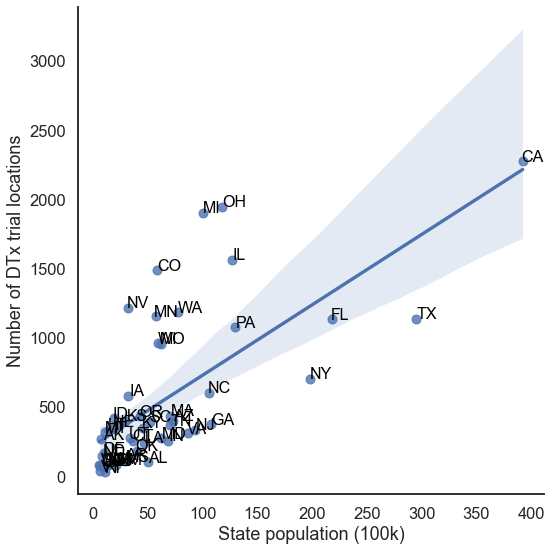

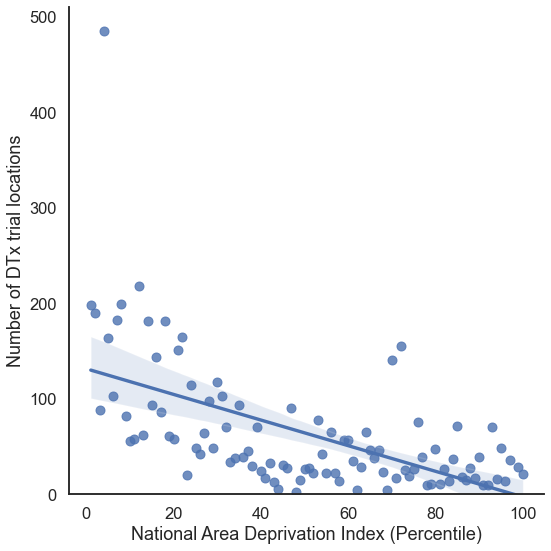

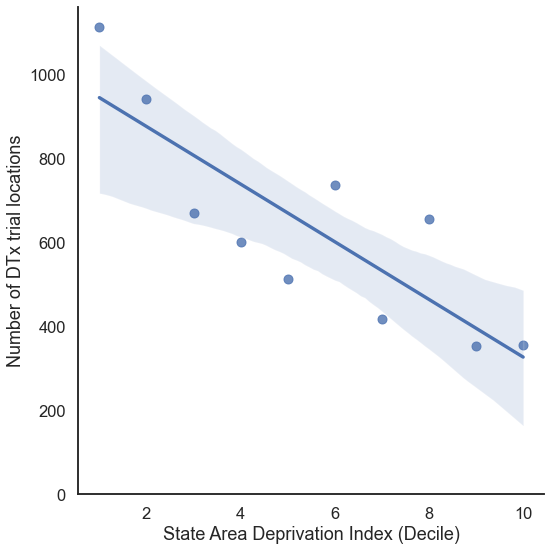

In [52]:
%run ./clinicalTrialFunctions.py

## Figure 2A: Locations by state
fig = plotGeographicDistributionbyState(clinical_df[["NCTId", "state_code"]], values=None, average="sum", log_value=None)
fig.show()
#fig.write_image("./dataOutput/figures/Figure2_Locations.pdf")
locations_df = clinical_df.explode(["LocationState"])
print(locations_df.value_counts("LocationState"))

## Supplemental figure S2A: Locations by state normalized to population
state_code_dict = {}
for m, n in zip(clinical_df["LocationState"], clinical_df["state_code"]):
    if m is not None and n is not None and type(m)!=float and type(n)!=float and len(m) == len(n): state_code_dict.update(dict(zip(m,n)))
fig, state_df = plotPerPopulationTrial(locations_df.value_counts("LocationState"), state_code_dict, normalize=10e4)
fig.show() # Normalized to population
fig = plotPopulationvsNumTrialLocations(state_df, min_label=22)
#fig.get_figure().savefig("./dataOutput/figures/FigureS2_TrialsVsStatePopulation.pdf")
print()

## Supplemental figure S2B: Number of clincal trial locations by ADI
# getLocationZipADI() takes some time to run
state_df = getLocationZipADI(clinical_df, states=["CA", "TX", "FL", "NY", "PA"])
clinical_df["ADI_NATRANK"] = clinical_df["NCTId"].map(state_df.groupby("NCTId")["ADI_NATRANK"].apply(list))
clinical_df["ADI_STATERNK"] = clinical_df["NCTId"].map(state_df.groupby("NCTId")["ADI_STATERNK"].apply(list))

fig = plotTrialLocationsPerADI(state_df, rank_type="ADI_NATRANK", height=8)
fig.set_xlabel("National Area Deprivation Index (Percentile)")
#fig.get_figure().savefig("./dataOutput/figures/FigureS2_TrialsVsADINational.pdf")

fig = plotTrialLocationsPerADI(state_df, rank_type="ADI_STATERNK", height=8)
fig.set_xlabel("State Area Deprivation Index (Decile)")
#fig.get_figure().savefig("./dataOutput/figures/FigureS2_TrialsVsADIState.pdf")

## Print average number of locations per trial (completed only)
clinical_df = clinical_df[clinical_df["OverallStatus"] == "Completed"]
#clinical_df = clinical_df[clinical_df["StudyType"] == "Interventional"]
print("Mean, min, max locations per completed trial: %.3f, %d, %d"%(clinical_df["NumberLocations"].mean(), clinical_df["NumberLocations"].min(), clinical_df["NumberLocations"].max()))
print("Studies with no locations: %d\n"%(len(clinical_df[clinical_df["NumberLocations"] == 0])))
print()

## Supplemental figure S2B: Number of locations vs enrollment (completed studies only)
clinical_df["Log10EnrollmentCount"] = np.log10(clinical_df["EnrollmentCount"])
lm = sns.lmplot(data = clinical_df, x = "NumberLocations", y= "Log10EnrollmentCount", height=10, )
ax = lm.axes[0,0]
ax.set_xlabel("Number of trial locations")
ax.set_ylabel("Enrollment (Log10)")   
print("#locations vs enrollment", spearmanr(clinical_df["NumberLocations"], clinical_df["Log10EnrollmentCount"]))



